In [1]:
from support_functions import *

pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])

np.random.seed(RANDOM_STATE)

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### GRID_SEARCH
**The variable below, `RUN_GRIDSEARCH` is used in this notebook as a decision to run the sklearn `GridSearchCV` with given parameters. A model param/metrics dataframe will then be dumped into the directory to replace the current df.**

**This process is computationally expensive and takes a very long time. With `RUN_GRIDSEARCH` set to False, a GridSearch will not be run, but rather the found optimizations will be fitted and shown graphically.**

In [2]:
RUN_GRIDSEARCH = False

# Modeling Goals
- The aim of the competition is a plain `accuracy_score` for unlabeled data.
- From a financial perspective, the allocation of maintenance resources is vital, therefore correctly labeling the pumps which are *functional needs repair* and *non functional* can be considered the most important.

## Reload Data
Reload from processing notebook.

In [3]:
os.listdir('processed_data/')

['.ipynb_checkpoints',
 'cat_feature_names.jobjib',
 'num_feature_names.jobjib',
 'unlabeled_y_df.csv',
 'X_test_df.csv',
 'X_train_df.csv',
 'y_test_enc.csv',
 'y_train_enc.csv']

In [4]:
label_enc = load('dumps/label_enc.jobjib')
LABEL_NAMES = label_enc.classes_
LABEL_NAMES

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [5]:
PIPELINE = load('dumps/preprocessing.jobjib')
PIPELINE

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'num_private', 'population',
                                  'years_old', 'tsh_exists', 'installed_by_DWE',
                                  'basin_Ruvuma / Southern Coast',
                                  'subvillage_Majengo', 'subvillage_Shuleni',
                                  'subvillage_Madukani', 'su...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encod

In [6]:
# For comclusion and recommendations.
X_original = pd.read_csv('train_values.csv')
y_original = pd.read_csv('train_labels.csv')['status_group']

# For modeling.
X_train = pd.read_csv('processed_data/X_train_df.csv', index_col=0)
X_test = pd.read_csv('processed_data/X_test_df.csv', index_col=0)
y_train = pd.read_csv('processed_data/y_train_enc.csv', 
                      index_col=0)['status_group']
y_test = pd.read_csv('processed_data/y_test_enc.csv', 
                     index_col=0)['status_group']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 137), (14850, 137), (44550,), (14850,))

In [7]:
REAL_TEST = pd.read_csv('processed_data/unlabeled_y_df.csv', index_col=0)
REAL_TEST.set_index('id', drop=True, inplace=True)
print(REAL_TEST.shape)
REAL_TEST.head()

(14850, 137)


amount_tsh  gps_height  longitude  latitude  num_private  population  \
id                                                                            
50785   -0.131809    1.917381   0.186597  0.556538    -0.052648    0.296047   
51630   -0.131809    1.301208   0.394140  0.811457    -0.052648    0.252012   
17168   -0.131809    1.298322   0.107139  0.235665    -0.052648    0.671394   
45559   -0.131809   -0.577616   0.607066 -1.263768    -0.052648    0.147166   
49871    0.087249    0.855312   0.143342 -1.784060    -0.052648   -0.251248   

       years_old  tsh_exists  installed_by_DWE  basin_Ruvuma / Southern Coast  \
id                                                                              
50785  -0.439584   -0.651262         -0.644278                      -0.284459   
51630   0.343914   -0.651262          1.552125                      -0.284459   
17168  -0.309001   -0.651262         -0.644278                      -0.284459   
45559   1.192704   -0.651262         -0.644278                       3.515440   
49871   0.343914    1.535481         -0.644278                       3.515440   

       subvillage_Majengo  subvillage_Shuleni  subvillage_Madukani  \
id                                                                   
50785           -0.093367           -0.093976            -0.091763   
51630           -0.093367           -0.093976            -0.091763   
17168           -0.093367           -0.093976            -0.091763   
45559           -0.093367           -0.093976            -0.091763   
49871           -0.093367           -0.093976            -0.091763   

       subvillage_Mtakuja  subvillage_Kati  region_Iringa  region_Arusha  \
id                                                                         
50785           -0.066646        -0.081784      -0.312521      -0.245016   
51630           -0.066646        -0.081784      -0.312521       4.081366   
17168           -0.066646        -0.081784      -0.312521      -0.245016   
45559           -0.066646        -0.081784      -0.312521      -0.245016   
49871           -0.066646        -0.081784      -0.312521      -0.245016   

       region_Tabora  region_Tanga  region_code_10  region_code_15  \
id                                                                   
50785      -0.184202     -0.213146       -0.216121        -0.17772   
51630      -0.184202     -0.213146       -0.216121        -0.17772   
17168      -0.184202     -0.213146       -0.216121        -0.17772   
45559      -0.184202     -0.213146       -0.216121        -0.17772   
49871      -0.184202     -0.213146        4.627035        -0.17772   

       district_code_4  district_code_3  lga_Bariadi  lga_Siha  \
id                                                               
50785        -0.419918         2.223324     -0.14179 -0.085459   
51630        -0.419918        -0.449777     -0.14179 -0.085459   
17168        -0.419918        -0.449777     -0.14179 -0.085459   
45559        -0.419918        -0.449777     -0.14179 -0.085459   
49871        -0.419918         2.223324     -0.14179 -0.085459   

       lga_Kigoma Rural  lga_Bagamoyo  lga_Pangani  lga_Babati  \
id                                                               
50785         -0.118118     -0.131299     -0.07421   -0.092259   
51630         -0.118118     -0.131299     -0.07421   -0.092259   
17168         -0.118118     -0.131299     -0.07421   -0.092259   
45559         -0.118118     -0.131299     -0.07421   -0.092259   
49871         -0.118118     -0.131299     -0.07421   -0.092259   

       lga_Lindi Rural  lga_Kasulu  lga_Bunda  funder_Government Of Tanzania  \
id                                                                             
50785         -0.08024   -0.133841  -0.083709                      -0.426039   
51630         -0.08024   -0.133841  -0.083709                       2.347201   
17168         -0.08024   -0.133841  -0.083709                      -0.426039   
45559         -0.08024   -0.133841  -0.08370

# Modeling
In this notebook, we will be using a dummy-classifier and three predictive models.
- Random Forest Classifier
- LinearSVC
- XGBoost Classifier

## Baseline - Dummy Classifier

In [8]:
# Set up baseline dummy-classifier which predicts 
# randomly based on the class distribution.
dummy_clf = DummyClassifier(random_state=RANDOM_STATE,
                            strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=51, strategy='stratified')

********************************************************************************
*                    Dummy Classifier Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.54      0.55      0.55      8065
functional needs repair       0.07      0.07      0.07      1079
         non functional       0.39      0.39      0.39      5706

               accuracy                           0.45     14850
              macro avg       0.34      0.34      0.34     14850
           weighted avg       0.45      0.45      0.45     14850



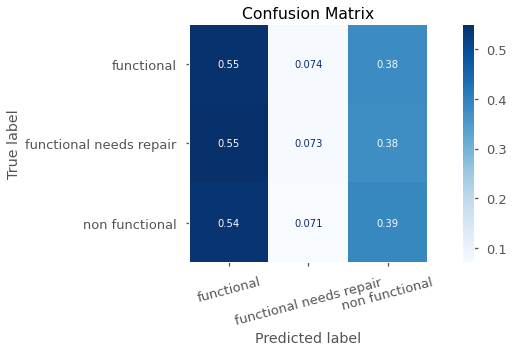

In [9]:
show_metrics(dummy_clf, X_test, y_test, 
             label='Dummy Classifier',
             target_names=LABEL_NAMES)

## Random Forest Classifier

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-03 07:42:08.396100            0.000000
1   Stop 2020-10-03 07:42:17.271457            8.875357

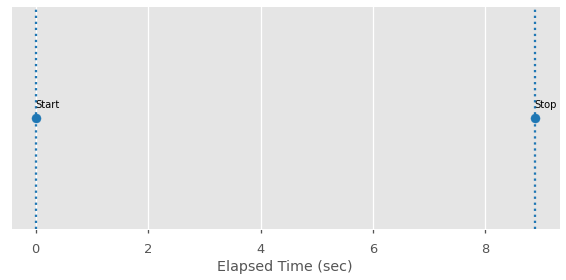

In [10]:
watch = Stopwatch()

# Starting with no parameter-tuning.
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*            Vanilla Random Forest Classifier Classification Report            *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.54      0.36      0.43      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.68      0.70     14850
           weighted avg       0.80      0.81      0.80     14850



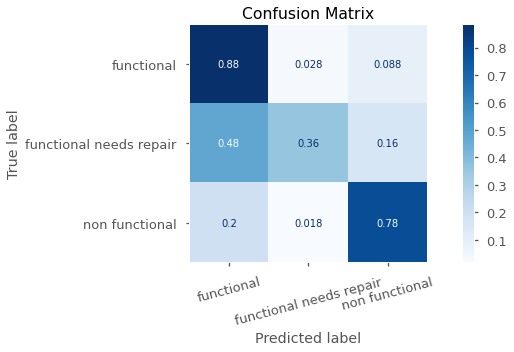

In [12]:
show_metrics(forest, X_test, y_test, 
             label='Vanilla Random Forest Classifier',
             target_names=LABEL_NAMES)

Having a vanilla Random Forest score `0.81` accuracy is pretty impressive. I feel that this might be a great model-type for this problem because of the number of categorical features and the robust-quality of a Forest. 

In [13]:
# Set up feature-importance df to plot.
feat_imp_dct = dict(
    feature = X_train.columns,
    importance = forest.feature_importances_
)
feat_imp = pd.DataFrame(feat_imp_dct)

feat_imp.sort_values('importance', ascending=False, inplace=True)
feat_imp.head(10)

feature  importance
3                       latitude    0.140303
2                      longitude    0.139093
1                     gps_height    0.068136
109                 quantity_dry    0.065532
6                      years_old    0.053381
5                     population    0.047908
110              quantity_enough    0.027152
75   extraction_type_group_other    0.021286
130        waterpoint_type_other    0.021264
0                     amount_tsh    0.020447

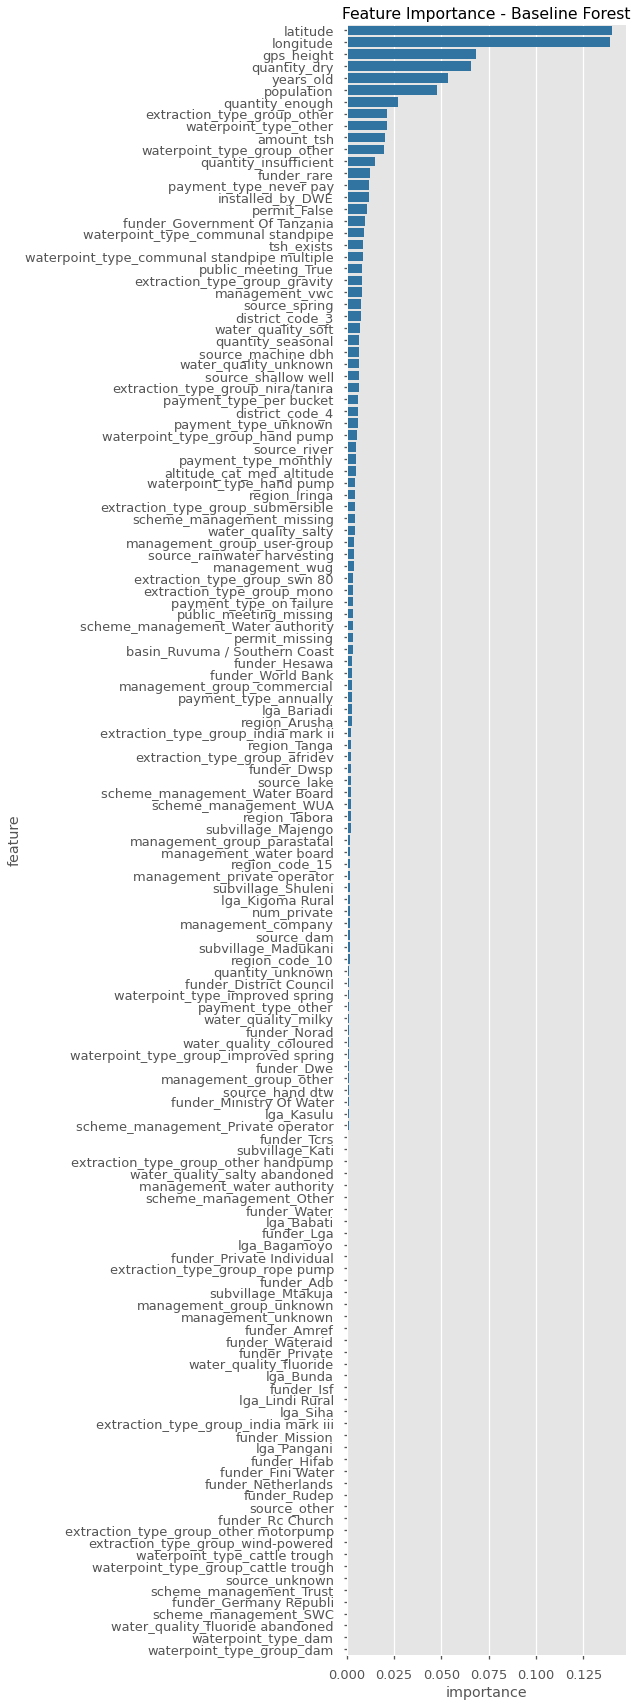

In [14]:
# Plot feature importances from vanilla model.
fig, ax = plt.subplots(figsize=(5,30))
sns.barplot(x='importance', y='feature', data=feat_imp, orient='h',
            color=COLOR, ax=ax)
ax.set(title='Feature Importance - Baseline Forest');

Interestingly, some of the top features are *locational* (`longitude` / `latitude` / `gps_height`).

### Forest GridSearch
For each model type, we will try to tune some parameters to optimize for different metrics.

In [15]:
FOREST_FNAME = 'forest_df.jobjib'

********************************************************************************
*                      RFC-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      8065
functional needs repair       0.67      0.25      0.37      1079
         non functional       0.86      0.75      0.80      5706

               accuracy                           0.81     14850
              macro avg       0.77      0.64      0.67     14850
           weighted avg       0.81      0.81      0.80     14850



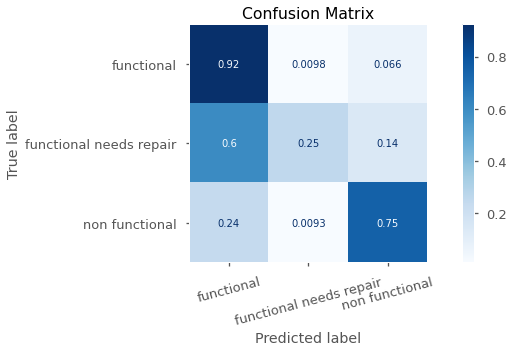

********************************************************************************
*                      RFC-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.53      0.35      0.42      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



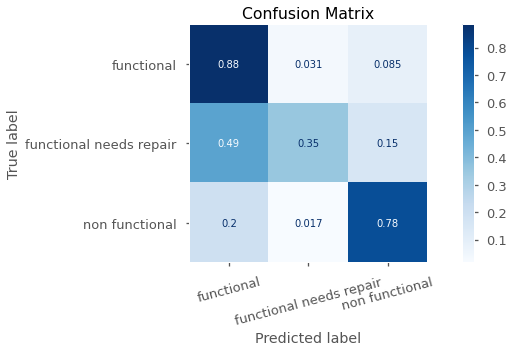

********************************************************************************
*                  RFC-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.76      0.94      0.84      8065
functional needs repair       0.71      0.18      0.29      1079
         non functional       0.87      0.70      0.78      5706

               accuracy                           0.79     14850
              macro avg       0.78      0.61      0.63     14850
           weighted avg       0.80      0.79      0.78     14850



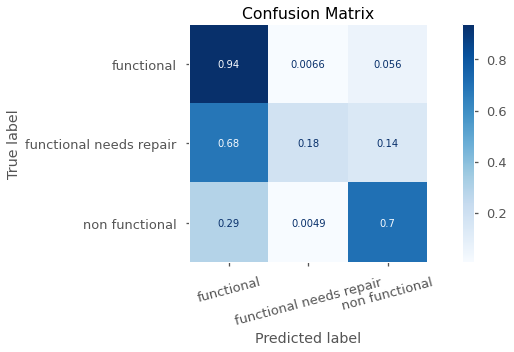

********************************************************************************
*                    RFC-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      8065
functional needs repair       0.53      0.35      0.42      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.72      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



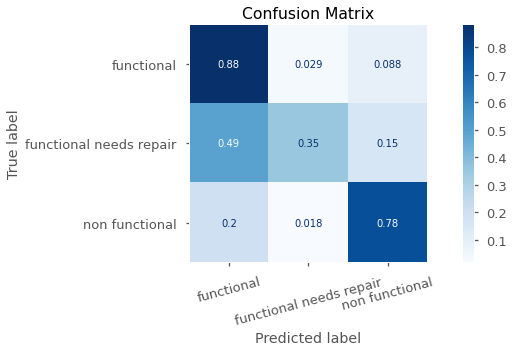

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-03 07:42:20.539716            0.000000
1         RFC-accuracy 2020-10-03 07:42:31.528406           10.988690
2         RFC-f1_macro 2020-10-03 07:42:42.466258           21.926542
3  RFC-precision_macro 2020-10-03 07:42:50.129834           29.590118
4     RFC-recall_macro 2020-10-03 07:43:01.019207           40.479491

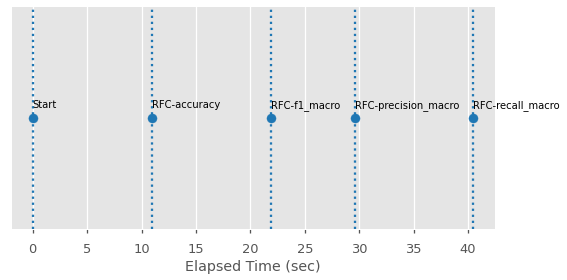

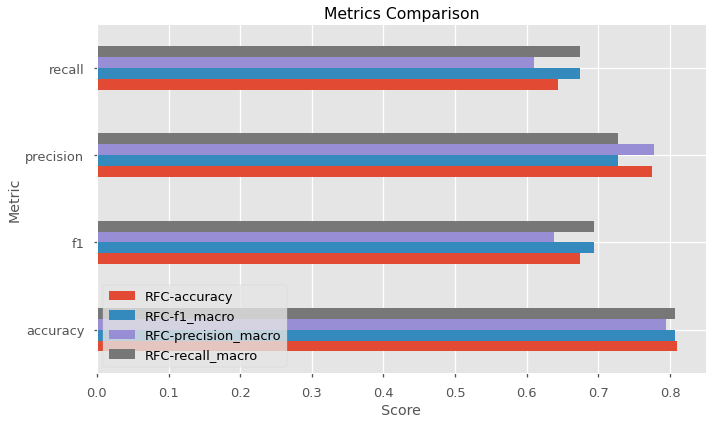

model_label                                        best_params  \
0         RFC-accuracy  {'bootstrap': False, 'criterion': 'gini', 'min...   
1         RFC-f1_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
2  RFC-precision_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
3     RFC-recall_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   

   accuracy        f1  precision    recall  
0  0.809226  0.674151   0.774674  0.643333  
1  0.807003  0.693925   0.727262  0.674195  
2  0.793939  0.638310   0.778300  0.610401  
3  0.807003  0.693925   0.727262  0.674195

In [16]:
# SEE NOTE ON `RUN_GRIDSEARCH`.
if RUN_GRIDSEARCH:
    forest_params = {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }
    
    forest_df = gridsearch_model(RandomForestClassifier,
                                 'RFC',
                                 forest_params,
                                 X_train, X_test, y_train, y_test, 
                                 target_names=LABEL_NAMES,
                                 scoring_metrics=['accuracy', 'f1', 
                                                  'precision', 'recall'],
                                 multiclass_default_average='macro')
    
    dump(forest_df, f'models/{FOREST_FNAME}')
    
# Else, load in data.
elif FOREST_FNAME in os.listdir('models/'):
    forest_df = load(f'models/{FOREST_FNAME}')
    show_metrics_for_df(forest_df,
                        RandomForestClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(forest_df)
forest_df

The model optimized for accuracy is very good with a 0.809 `accuracy`, however it leaves some to be desired with its low `recall_macro`.
> Recall with a **macro-weight** is a harsher metric than "weighted" because it finds a balance between the categories equally, rather than making it more important to correctly identify the more-common categories.

## K-Nearest Neighbors (KNN)

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-03 07:43:01.335654            0.000000
1   Stop 2020-10-03 07:43:04.529175            3.193521

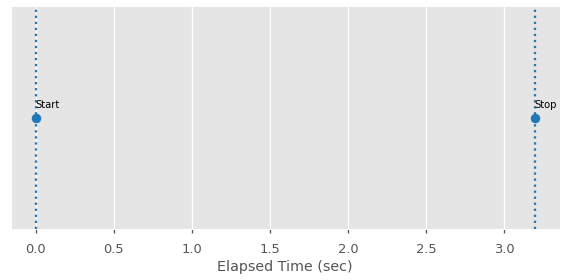

In [17]:
watch = Stopwatch()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*                     KNN Classifier Classification Report                     *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.86      0.81      8065
functional needs repair       0.48      0.31      0.38      1079
         non functional       0.80      0.72      0.75      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



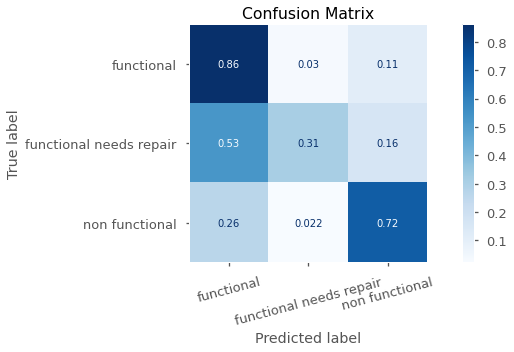

In [18]:
show_metrics(knn, X_test, y_test, 
             label='KNN Classifier',
             target_names=LABEL_NAMES)

### KNN GridSearch

In [19]:
KNN_FNAME = 'knn_df.jobjib'

********************************************************************************
*                      KNN-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



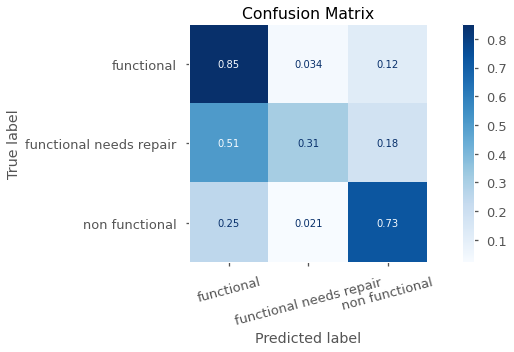

********************************************************************************
*                      KNN-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



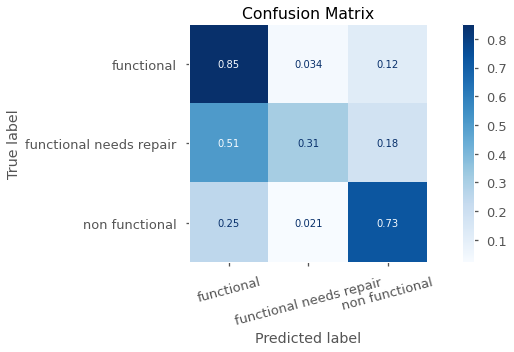

********************************************************************************
*                  KNN-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.75      0.86      0.81      8065
functional needs repair       0.55      0.28      0.37      1079
         non functional       0.78      0.69      0.73      5706

               accuracy                           0.75     14850
              macro avg       0.69      0.61      0.64     14850
           weighted avg       0.75      0.75      0.75     14850



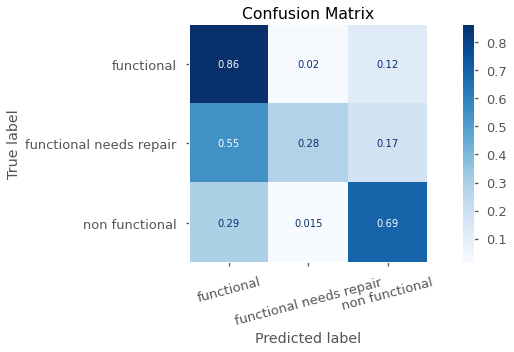

********************************************************************************
*                    KNN-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



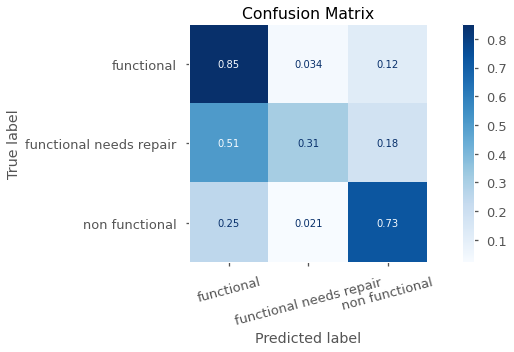

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-03 07:44:48.485707            0.000000
1         KNN-accuracy 2020-10-03 07:46:24.145719           95.660012
2         KNN-f1_macro 2020-10-03 07:48:02.115348          193.629641
3  KNN-precision_macro 2020-10-03 07:50:04.572969          316.087262
4     KNN-recall_macro 2020-10-03 07:51:40.240840          411.755133

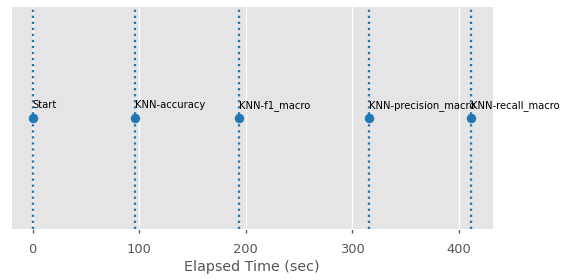

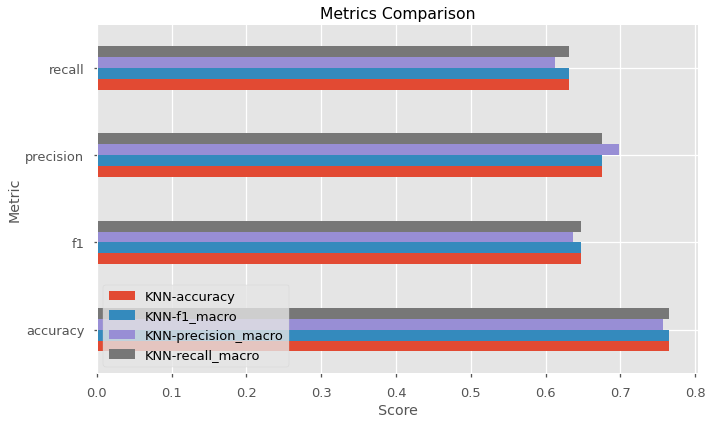

model_label         best_params  accuracy        f1  precision  \
0         KNN-accuracy  {'n_neighbors': 3}  0.765589  0.647659   0.675512   
1         KNN-f1_macro  {'n_neighbors': 3}  0.765589  0.647659   0.675512   
2  KNN-precision_macro  {'n_neighbors': 9}  0.756566  0.637257   0.697740   
3     KNN-recall_macro  {'n_neighbors': 3}  0.765589  0.647659   0.675512   

     recall  
0  0.631222  
1  0.631222  
2  0.612245  
3  0.631222

In [20]:
if RUN_GRIDSEARCH:
    knn_params = {
        'n_neighbors': [3, 5, 7, 9]
    }

    knn_df = gridsearch_model(KNeighborsClassifier,
                              'KNN',
                              knn_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{KNN_FNAME}')
    
elif KNN_FNAME in os.listdir('models/'):
    knn_df = load(f'models/{KNN_FNAME}')
    show_metrics_for_df(knn_df,
                        KNeighborsClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(knn_df)
knn_df

These models aren't showing as much accuracy as the Random Forests, nor do they seem to be better at finding the minority class `functional needs repair`.

## XGBoost

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-03 07:51:40.492341            0.000000
1   Stop 2020-10-03 07:52:08.423934           27.931593

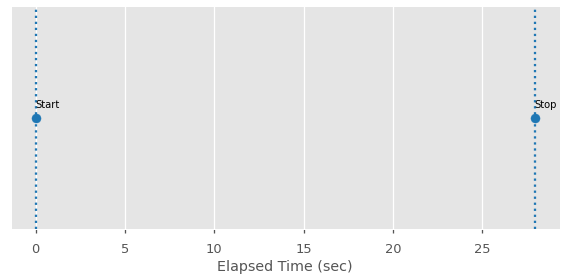

In [21]:
watch = Stopwatch()

xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*                 Vanilla XGBClassifier Classification Report                  *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.72      0.93      0.81      8065
functional needs repair       0.61      0.12      0.21      1079
         non functional       0.84      0.61      0.71      5706

               accuracy                           0.75     14850
              macro avg       0.72      0.55      0.57     14850
           weighted avg       0.76      0.75      0.73     14850



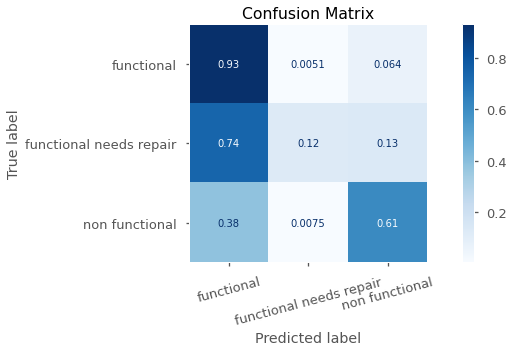

In [22]:
show_metrics(xgb, X_test, y_test, 
             label='Vanilla XGBClassifier',
             target_names=LABEL_NAMES)

### XGB GridSearch

In [23]:
XGB_FNAME = 'xgb_df.jobjib'

********************************************************************************
*                      xgb-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



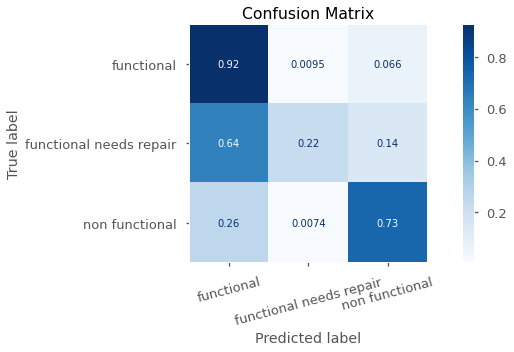

********************************************************************************
*                      xgb-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



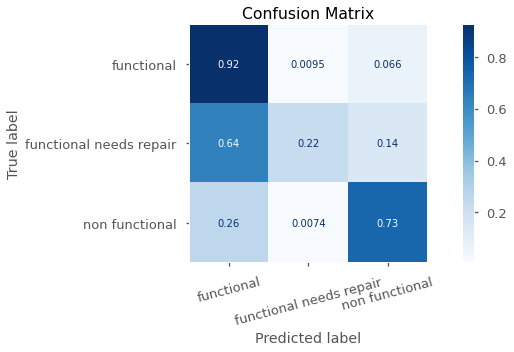

********************************************************************************
*                  xgb-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



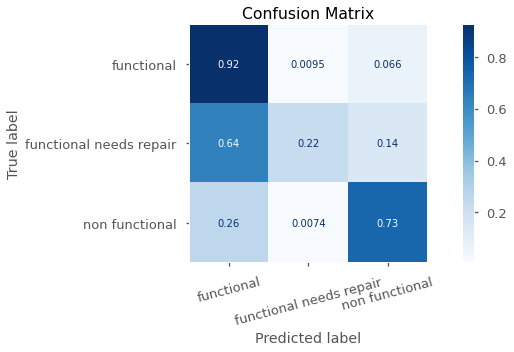

********************************************************************************
*                    xgb-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



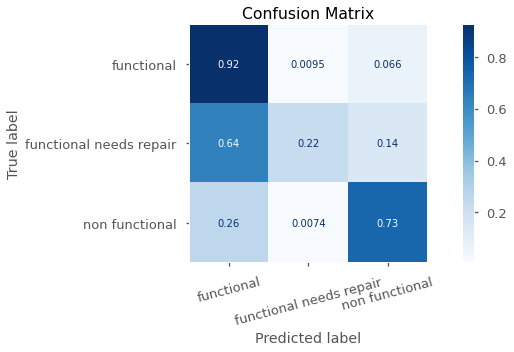

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-03 07:52:09.383835            0.000000
1         xgb-accuracy 2020-10-03 07:53:23.052926           73.669091
2         xgb-f1_macro 2020-10-03 07:54:38.676702          149.292867
3  xgb-precision_macro 2020-10-03 07:55:53.625239          224.241404
4     xgb-recall_macro 2020-10-03 07:57:09.305498          299.921663

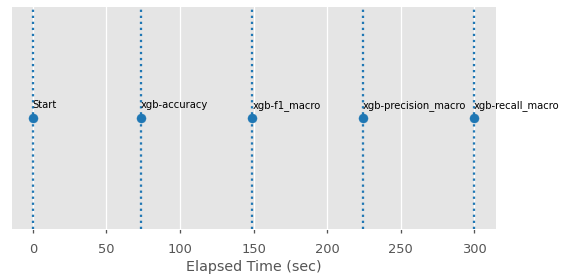

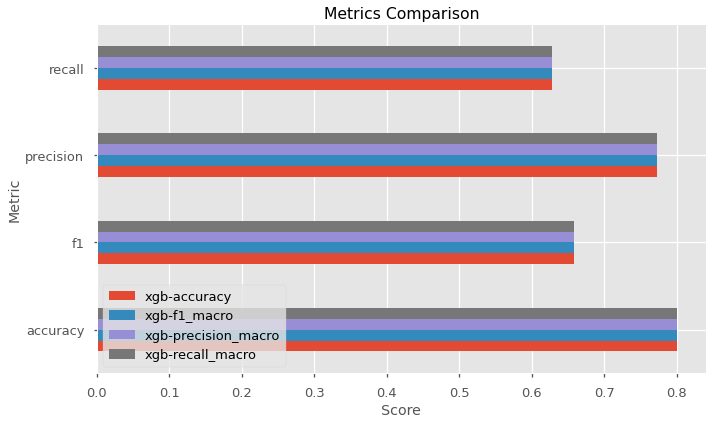

model_label                             best_params  accuracy  \
0         xgb-accuracy  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
1         xgb-f1_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
2  xgb-precision_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
3     xgb-recall_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   

         f1  precision    recall  
0  0.657927   0.772328  0.627689  
1  0.657927   0.772328  0.627689  
2  0.657927   0.772328  0.627689  
3  0.657927   0.772328  0.627689

In [24]:
if RUN_GRIDSEARCH:
    xgb_params = {
        'max_depth': [3, 5, 7]
    }

    xgb_df = gridsearch_model(XGBClassifier,
                              'XGB',
                              xgb_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{XGB_FNAME}')
    
elif XGB_FNAME in os.listdir('models/'):
    xgb_df = load(f'models/{XGB_FNAME}')
    show_metrics_for_df(xgb_df,
                        XGBClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(xgb_df)
xgb_df

The XGB models are tending to prioritize over-guessing the most common target variable - `functional`.

# Class Imbalance: SMOTE-NC
There are certainly some decent results, but a more balanced training set might help the models predict the minority classes.

- **SMOTENC** is a version of *SMOTE* which can handle one-hot-encoded columns by indicating which columns to treat as categorical.
- It will then create new data points (synthetically) to train on with hopes to get better modeling results.

In [25]:
# Loading columns from processing notebook.
categorical_columns = load('processed_data/cat_feature_names.jobjib')
numerical_columns = load('processed_data/num_feature_names.jobjib')

print('Num:', len(numerical_columns),' Cat:', len(categorical_columns))

Num: 57  Cat: 80


In [26]:
# Get column indexes which are categorical.
cat_col_idxs = np.array([list(X_train.columns).index(c) 
                         for c in categorical_columns])

# Use SMOTENC for continuous and categorical columns.
smote = SMOTENC(random_state=RANDOM_STATE, 
                categorical_features=cat_col_idxs)
smote

SMOTENC(categorical_features=array([ 57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136]),
        random_state=51)

In [27]:
# Synthesize training data to redistribute target classes.
string1 = 'Original Class Distribution'
print(headerize(string1))
print(y_train.value_counts(normalize=True))

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

string2 = 'Resampled Distribution'
print(headerize(string2))
print(pd.Series(y_train_res).value_counts(normalize=True))

********************************************************************************
*                         Original Class Distribution                          *
********************************************************************************
0    0.543075
2    0.384242
1    0.072682
Name: status_group, dtype: float64
********************************************************************************
*                            Resampled Distribution                            *
********************************************************************************
2    0.333333
1    0.333333
0    0.333333
Name: status_group, dtype: float64


## Fit re-sampled data.

rfc
knn
xgb


Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-03 07:59:17.973754            0.000000
1    rfc 2020-10-03 07:59:35.632522           17.658768
2    knn 2020-10-03 07:59:43.484519           25.510765
3    xgb 2020-10-03 08:01:45.680735          147.706981

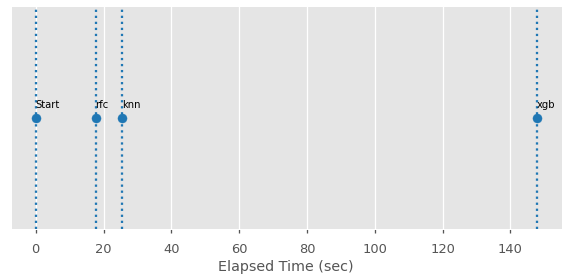

[(RandomForestClassifier(bootstrap=False, min_samples_leaf=3), 'rfc'),
 (KNeighborsClassifier(n_neighbors=3), 'knn'),
 (XGBClassifier(max_depth=9, objective='multi:softprob'), 'xgb')]

In [28]:
# Get best accuracy model-params for each model type.
best_params_df_lst = [
    (RandomForestClassifier, forest_df, 'rfc'),
    (KNeighborsClassifier, knn_df, 'knn'),
    (XGBClassifier, xgb_df, 'xgb')
]

# Instantiate each model with its best accuracy params.
watch = Stopwatch()

models = []
for model, df, name in best_params_df_lst:
    params = df.iloc[0]['best_params']  # accuracy
    
    # Fit with synthesized data.
    m = model(**params).fit(X_train_res, y_train_res)
    models.append((m, name))
    
    print(headerize(name))
    watch.lap(label=name)
    
watch.stop()
watch.display_laps(show_stop=False)

models

********************************************************************************
*                          rfc Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8065
functional needs repair       0.34      0.58      0.43      1079
         non functional       0.84      0.76      0.80      5706

               accuracy                           0.78     14850
              macro avg       0.67      0.72      0.68     14850
           weighted avg       0.80      0.78      0.78     14850



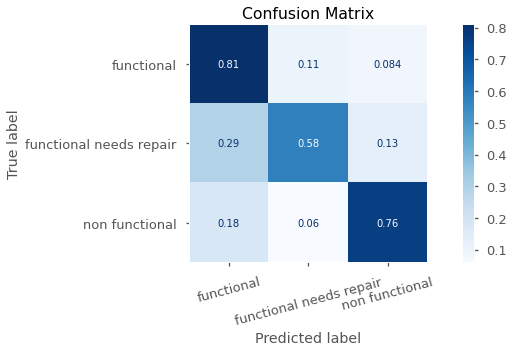

********************************************************************************
*                          knn Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.80      0.78      0.79      8065
functional needs repair       0.33      0.46      0.38      1079
         non functional       0.77      0.75      0.76      5706

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.64     14850
           weighted avg       0.75      0.74      0.75     14850



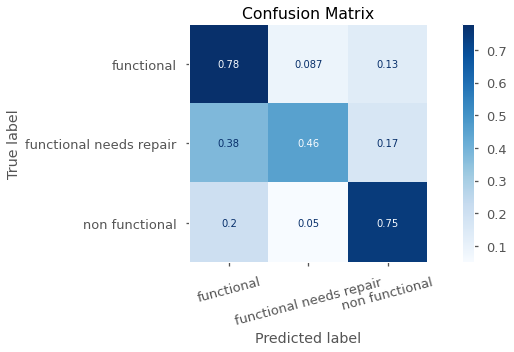

********************************************************************************
*                          xgb Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.82      0.77      0.80      8065
functional needs repair       0.29      0.62      0.39      1079
         non functional       0.84      0.73      0.78      5706

               accuracy                           0.74     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.74      0.76     14850



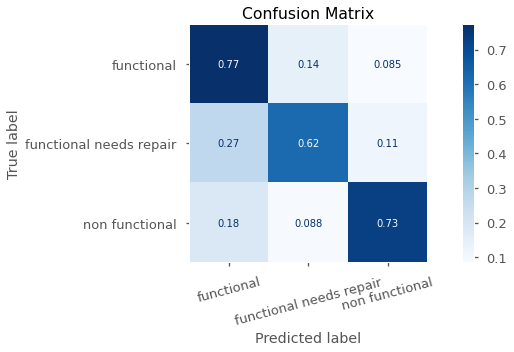

In [29]:
# Evaluate performance.
for model, name in models:
    show_metrics(model, X_test, y_test, 
                 label=name,
                 target_names=LABEL_NAMES)

In some ways, these models are performing much better than with the unbalanced training data.
- They are predicting the minority class *much* more accurately.
- The f1-macro score has increased.

However, their accuracy has diminished due in large part to the number of the majority class (*functional*) which are being mislabeled.

***

Finally, I'm going to try an ensemble with these three classifiers with the SMOTE data to improve the final predictions.

# Creating an Ensemble

In [30]:
# Select what metric to use for the optimized models.
model_optimization_dct = {
    'accuracy': 0,
    'f1_macro': 1,
    'precision_macro': 2,
    'recall_macro': 3
}

# Selecting metric.
OPTIMIZATION_SELECTION = model_optimization_dct['accuracy']
OPTIMIZATION_SELECTION

0

In [31]:
# Our `models` list has models which have already been fit.
unfit_models = []
for clf, df, name in best_params_df_lst:
    params = df.iloc[OPTIMIZATION_SELECTION]['best_params']
    unfit_models.append((name, clf(**params)))
unfit_models

[('rfc', RandomForestClassifier(bootstrap=False, min_samples_leaf=3)),
 ('knn', KNeighborsClassifier(n_neighbors=3)),
 ('xgb', XGBClassifier(max_depth=9))]

## Train Separately on Resampled Data and Original Data

********************************************************************************
*                                   Original                                   *
********************************************************************************
********************************************************************************
*           Stacking Classifier: Original Data Classification Report           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8065
functional needs repair       0.64      0.30      0.40      1079
         non functional       0.85      0.77      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.76      0.66      0.69     14850
           weighted avg       0.81      0.81      0.80     14850



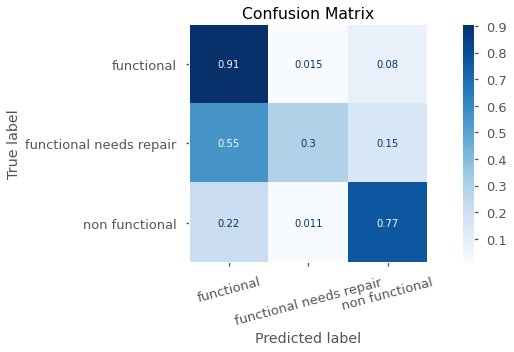

********************************************************************************
*                                  Resampled                                   *
********************************************************************************
********************************************************************************
*          Stacking Classifier: Resampled Data Classification Report           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8065
functional needs repair       0.37      0.49      0.42      1079
         non functional       0.82      0.79      0.80      5706

               accuracy                           0.78     14850
              macro avg       0.67      0.70      0.68     14850
           weighted avg       0.79      0.78      0.78     14850



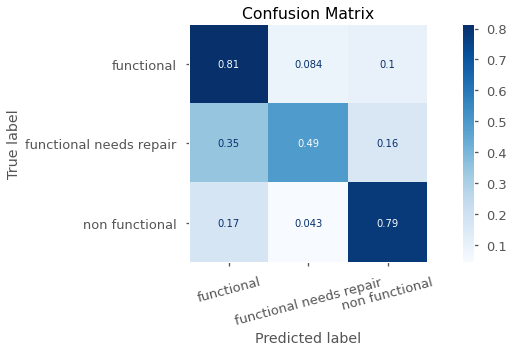

Label                  Timestamp  Elapsed Time (min)
0      Start 2020-10-03 08:04:09.016085                0.00
1   Original 2020-10-03 08:15:07.770309               10.98
2  Resampled 2020-10-03 08:34:52.730745               30.73

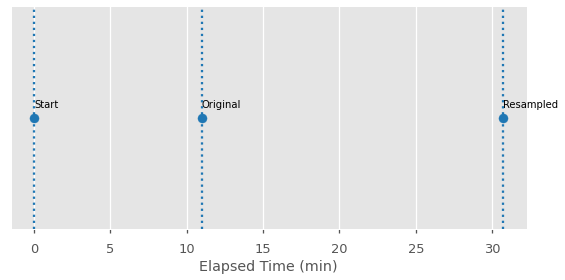

In [32]:
data = [
    (X_train, y_train, 'Original'),
    (X_train_res, y_train_res, 'Resampled')
]

clf_dct = {}

watch = Stopwatch()
for X, y, label in data:
    print(headerize(label))
    stack_clf = StackingClassifier(estimators=unfit_models)
    stack_clf.fit(X, y)

    show_metrics(stack_clf,
                 X_test, 
                 y_test, 
                 label=f'Stacking Classifier: {label} Data',
                 target_names=LABEL_NAMES)
    clf_dct[label] = stack_clf
    watch.lap(label=label)
    
watch.display_laps(minutes_elapsed=True)

In [33]:
clf_dct

{'Original': StackingClassifier(estimators=[('rfc',
                                 RandomForestClassifier(bootstrap=False,
                                                        min_samples_leaf=3)),
                                ('knn', KNeighborsClassifier(n_neighbors=3)),
                                ('xgb', XGBClassifier(max_depth=9))]),
 'Resampled': StackingClassifier(estimators=[('rfc',
                                 RandomForestClassifier(bootstrap=False,
                                                        min_samples_leaf=3)),
                                ('knn', KNeighborsClassifier(n_neighbors=3)),
                                ('xgb', XGBClassifier(max_depth=9))])}

These are two very interesting models.
***
**Original Training Data Model**
- On one hand, we have a model which has a higher overall accuracy (0.81).
- **0.9 recall** for functional water pumps, **0.77 recall** for non-functional pumps.
- The drawback is that more functional needs repair pumps are mislabeled than labeled correctly.

**Resampled Training Data Model**
- The first point to note is the 
- The accuracy is lower (**0.78**), but non functional recall is improved slightly (from 0.77 to **0.79**)
- This model would be good if you especially wanted to try and catch a water pump before it became non functional if it were cheaper to repair it.improvement in the minority class functional needs repair.

# REAL_TEST predictions

In [34]:
X_test_real = REAL_TEST.reset_index(drop=True)
X_test_real

amount_tsh  gps_height  longitude  latitude  num_private  population  \
0       -0.131809    1.917381   0.186597  0.556538    -0.052648    0.296047   
1       -0.131809    1.301208   0.394140  0.811457    -0.052648    0.252012   
2       -0.131809    1.298322   0.107139  0.235665    -0.052648    0.671394   
3       -0.131809   -0.577616   0.607066 -1.263768    -0.052648    0.147166   
4        0.087249    0.855312   0.143342 -1.784060    -0.052648   -0.251248   
...           ...         ...        ...       ...          ...         ...   
14845   -0.131809   -0.913841   0.727804 -0.300509    -0.052648   -0.335124   
14846    0.306308   -0.962904   0.514924  0.118110    -0.052648    5.829802   
14847   -0.131809    1.167006   0.102876  0.377906    -0.052648    0.042320   
14848   -0.131809    0.477238   0.208163 -1.659653    -0.052648   -0.062525   
14849   -0.131809   -0.268807   0.106713 -1.877674    -0.052648   -0.293186   

       years_old  tsh_exists  installed_by_DWE  basin_Ruvuma / Southern Coast  \
0      -0.439584   -0.651262         -0.644278                      -0.284459   
1       0.343914   -0.651262          1.552125                      -0.284459   
2      -0.309001   -0.651262         -0.644278                      -0.284459   
3       1.192704   -0.651262         -0.644278                       3.515440   
4       0.343914    1.535481         -0.644278                       3.515440   
...          ...         ...               ...                            ...   
14845   1.127413   -0.651262         -0.644278                      -0.284459   
14846   0.735664    1.535481         -0.644278                      -0.284459   
14847  -0.309001   -0.651262         -0.644278                      -0.284459   
14848  -0.243710   -0.651262          1.552125                      -0.284459   
14849  -0.178418   -0.651262         -0.644278                      -0.284459   

       subvillage_Majengo  subvillage_Shuleni  subvillage_Madukani  \
0               -0.093367           -0.093976            -0.091763   
1               -0.093367           -0.093976            -0.091763   
2               -0.093367           -0.093976            -0.091763   
3               -0.093367           -0.093976            -0.091763   
4               -0.093367           -0.093976            -0.091763   
...                   ...                 ...                  ...   
14845           -0.093367           -0.093976            -0.091763   
14846           -0.093367           -0.093976            -0.091763   
14847           -0.093367           -0.093976            -0.091763   
14848           -0.093367           -0.093976            -0.091763   
14849           -0.093367           -0.093976            -0.091763   

       subvillage_Mtakuja  subvillage_Kati  region_Iringa  region_Arusha  \
0               -0.066646        -0.081784      -0.312521      -0.245016   
1               -0.066646        -0.081784      -0.312521       4.081366   
2               -0.066646        -0.081784      -0.312521      -0.245016   
3               -0.066646        -0.081784      -0.312521      -0.245016   
4               -0.066646        -0.081784      -0.312521      -0.245016   
...                   ...              ...            ...            ...   
14845           -0.066646        -0.081784      -0.312521      -0.245016   
14846           -0.066646        -0.081784      -0.312521      -0.245016   
14847           -0.066646        -0.081784      -0.312521      -0.245016   
14848           -0.066646        -0.081784      -0.312521      -0.245016   
14849           -0.066646        -0.081784      -0.312521      -0.245016   

       region_Tabora  region_Tanga  region_code_10  region_code_15  \
0          -0.184202     -0.213146       -0.216121        -0.17772   
1          -0.184202     -0.213146       -0.216121        -0.17772   
2          -0.184202     -0.213146       -0.216121        -0.17772   
3          -0.184202     -0.213146       -0.216121 

In [35]:
y_ids = REAL_TEST.reset_index()[['id']]
y_ids

id
0      50785
1      51630
2      17168
3      45559
4      49871
...      ...
14845  39307
14846  18990
14847  28749
14848  33492
14849  68707

[14850 rows x 1 columns]

## Random Forest Predictions - Original Data

In [36]:
forest_df

model_label                                        best_params  \
0         RFC-accuracy  {'bootstrap': False, 'criterion': 'gini', 'min...   
1         RFC-f1_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
2  RFC-precision_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
3     RFC-recall_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   

   accuracy        f1  precision    recall  
0  0.809226  0.674151   0.774674  0.643333  
1  0.807003  0.693925   0.727262  0.674195  
2  0.793939  0.638310   0.778300  0.610401  
3  0.807003  0.693925   0.727262  0.674195

In [37]:
params = forest_df.iloc[0]['best_params']
params['random_state'] = RANDOM_STATE

rfc_final = RandomForestClassifier(**params)
rfc_final.fit(X_train, y_train)
rfc_final

RandomForestClassifier(bootstrap=False, min_samples_leaf=3, random_state=51)

In [38]:
y_ids['RFC'] = rfc_final.predict(X_test_real)
y_ids

id  RFC
0      50785    2
1      51630    0
2      17168    0
3      45559    2
4      49871    0
...      ...  ...
14845  39307    2
14846  18990    0
14847  28749    0
14848  33492    0
14849  68707    2

[14850 rows x 2 columns]

## Ensemble Predictions

In [39]:
for k in clf_dct.keys():
    y_ids[k] = clf_dct[k].predict(X_test_real)
    
y_ids

id  RFC  Original  Resampled
0      50785    2         2          2
1      51630    0         0          0
2      17168    0         0          0
3      45559    2         2          2
4      49871    0         0          0
...      ...  ...       ...        ...
14845  39307    2         2          2
14846  18990    0         0          0
14847  28749    0         0          0
14848  33492    0         0          0
14849  68707    2         2          2

[14850 rows x 4 columns]

## Submissions

In [40]:
# Inverse transform the target.
y_ids_inv = y_ids.copy()

y_ids_inv['RFC'] = label_enc.inverse_transform(y_ids['RFC'])
y_ids_inv['Original'] = label_enc.inverse_transform(y_ids['Original'])
y_ids_inv['Resampled'] = label_enc.inverse_transform(y_ids['Resampled'])

y_ids_inv

id             RFC        Original       Resampled
0      50785  non functional  non functional  non functional
1      51630      functional      functional      functional
2      17168      functional      functional      functional
3      45559  non functional  non functional  non functional
4      49871      functional      functional      functional
...      ...             ...             ...             ...
14845  39307  non functional  non functional  non functional
14846  18990      functional      functional      functional
14847  28749      functional      functional      functional
14848  33492      functional      functional      functional
14849  68707  non functional  non functional  non functional

[14850 rows x 4 columns]

In [41]:
def format_for_competition(dataframe, col):
    """Return a reformatted slice of the dataframe to submit."""
    submission = dataframe[['id', col]].copy()
    submission.columns = ['id', 'status_group']
    return submission

In [42]:
rfc_submission = format_for_competition(y_ids_inv, 'RFC')
rfc_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [43]:
original_submission = format_for_competition(y_ids_inv, 'Original')
original_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [44]:
resampled_submission = format_for_competition(y_ids_inv, 'Resampled')
resampled_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [45]:
rfc_submission.to_csv('competition_predictions/rfc.csv', 
                      index=False)
original_submission.to_csv('competition_predictions/original.csv', 
                           index=False)
resampled_submission.to_csv('competition_predictions/resampled.csv', 
                            index=False)

# Results
**Random Forest - Original Sampling**
<img src='rfc_results.png'>
**Ensemble - Original Sampling Method**
<img src='original_sample_results.png'>
**Ensemble - Post-SMOTE-NC Sampling**
<img src='resampled_results.png'>

# Conclusion & Final Model

While the Ensemble Classifier improved performance by 3%, the computational cost of training the three different classifiers and retrieving their predictions is very large.
Therefore, if I were to deploy a model, I would pick the **Random Forest Classifier**.

The Random Forest has the added benefits of being highly interpretable, very robust to noise and outliers, and is prone not to overfit. 

In [46]:
rfc_final

RandomForestClassifier(bootstrap=False, min_samples_leaf=3, random_state=51)

## Metrics
### Full

********************************************************************************
*                   Final Model - RFC Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      8065
functional needs repair       0.67      0.25      0.37      1079
         non functional       0.86      0.75      0.80      5706

               accuracy                           0.81     14850
              macro avg       0.77      0.64      0.67     14850
           weighted avg       0.81      0.81      0.80     14850



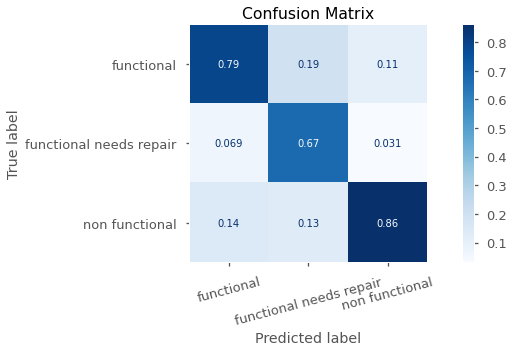

In [47]:
# Show metrics on test data predictions (normalized for precision).
show_metrics(rfc_final, X_test, y_test,
             label='Final Model - RFC', 
             normalize='pred',
             target_names=LABEL_NAMES)

- Out of the predicted values, 11% of non-functional wells were mislabeled as functional, while 18% of wells needing repair were functional.
- If the model predicted a functional well, it was correct 79% of the time.

### Binary

In [48]:
# Check functional / other labeling.
label_dct = {
    0: 'functional',
    1: 'needs_repair/non_functional',
    2: 'needs_repair/non_functional'
}

# Get predictions and map to binary.
binary_pred = pd.Series(rfc_final.predict(X_test)).map(label_dct)
binary_true = y_test.map(label_dct)
label_lst = ['functional', 'needs_repair/non_functional']

# Show classification report / confusion matrix.
print(metrics.classification_report(binary_true, binary_pred, 
                                    target_names=label_lst))

array = metrics.confusion_matrix(binary_true, binary_pred)
cm = pd.DataFrame(array, index=label_lst, columns=label_lst)
display(cm)

                             precision    recall  f1-score   support

                 functional       0.79      0.92      0.85      8065
needs_repair/non_functional       0.89      0.70      0.78      6785

                   accuracy                           0.82     14850
                  macro avg       0.84      0.81      0.82     14850
               weighted avg       0.83      0.82      0.82     14850



functional  needs_repair/non_functional
functional                         7451                          614
needs_repair/non_functional        2013                         4772

- When predicting wells that are not `class_0` (not **functional**), it is correct 88.9% of the time.
 - *(Precision score for `needs_repair/non_functional`)*
- The model is clearly very reliable when asked to find non-functioning wells.
- **Using this model to drive maintenance plans will reduce the number of `non-functional` / `needs repairs` wells by 69.875%.**
 - $\frac{correctly identified}{total existing}$

## Trees

- The `RandomForestClassifier` is an ensemble of n-`DecisionTreeClassifier`s. This model has the default 100 Decision Trees.
- Each tree is fit on a different subset of the training data and therefore has different *opinions* on determining the classification. These trees vote and the Forest uses all of its trees to pick a classification.
- Because of this, we can look "under the hood" at these trees and how they work.

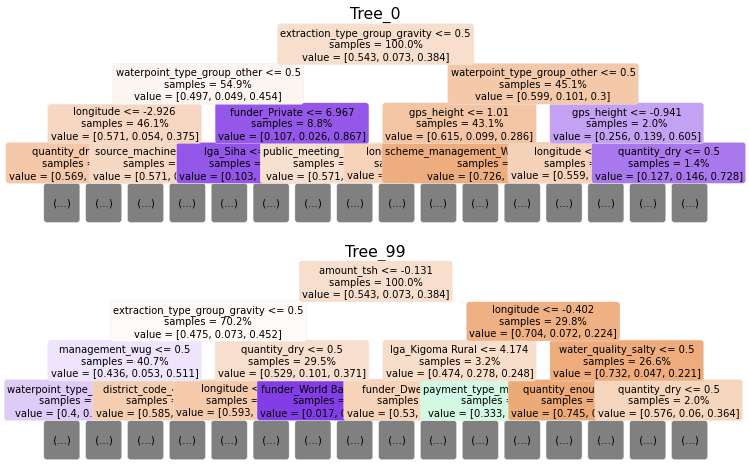

In [67]:
# Show example Decision Trees within forest.
tree0 = rfc_final.estimators_[0]
tree1 = rfc_final.estimators_[99]

fig, ax_lst = plt.subplots(nrows=2, figsize=(12,8))
for n, tree, ax in zip((0, 99), (tree0, tree1), ax_lst):
    plot_tree(tree,
              feature_names=X_train.columns,
              max_depth=3,
              filled=True,
              impurity=False,
              proportion=True,
              fontsize=10,
              rounded=True,
              ax=ax)
    ax.set(title=f'Tree_{n}')
plt.show()

- Orange: `functional`
- Green: `functional needs repair`
- Purple: `non functional`
***
- Each tree above is showing the first three splits for space, but will split down until there are 3 entries per "leaf" which will then determine the classification.
- `Tree_0` uses `quantity_enough` to split into a group where (on the left) 52% of entries are `non functional` and (on the right) 65% of entries are `functional`.
 - ...and so on...

### Feature Importances

In [50]:
def plot_feature_importances(clf, cols, n_features, ax, color=COLOR):
    """Plot `feature_importances_` from a DecisionTree or RandomForest."""
    df = pd.DataFrame({'feature': cols,
                       'importance': clf.feature_importances_})
    df.sort_values('importance', ascending=False, inplace=True)
    df = df.head(n_features)
    sns.barplot(x='importance', y='feature', color=color, data=df, ax=ax)

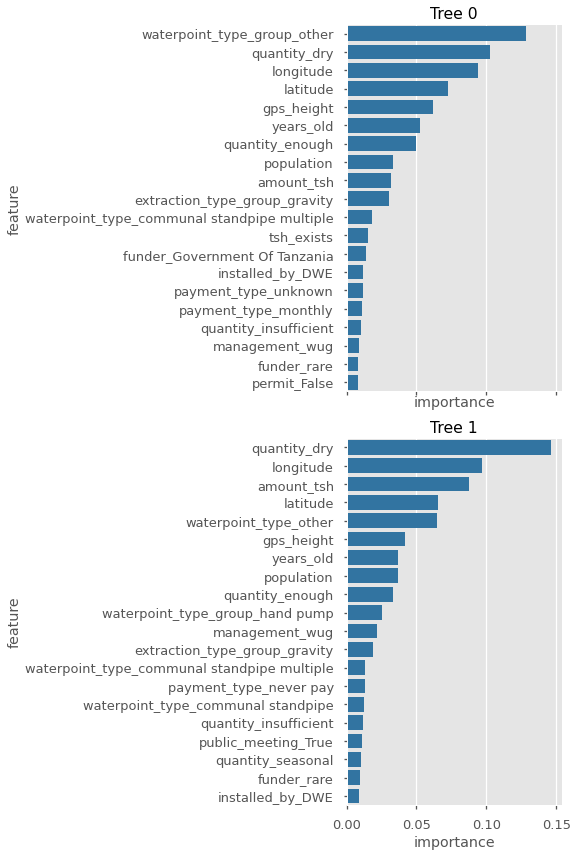

In [51]:
# Plot top 20 features for each tree.
fig, ax_lst = plt.subplots(nrows=2, sharex=True, figsize=(8, 12))
for n, (ax, tree) in enumerate(zip(ax_lst, (tree0, tree1))):
    plot_feature_importances(tree, X_test.columns, 20, ax)
    ax.set(title=f'Tree {n}')
fig.tight_layout()

- As you can see the feature importances of these two trees are massively different.
- The trees share an opinion of the relative importance of the `latitude`, `longitude`, and `gps_height` columns.

## Forest Feature Importances

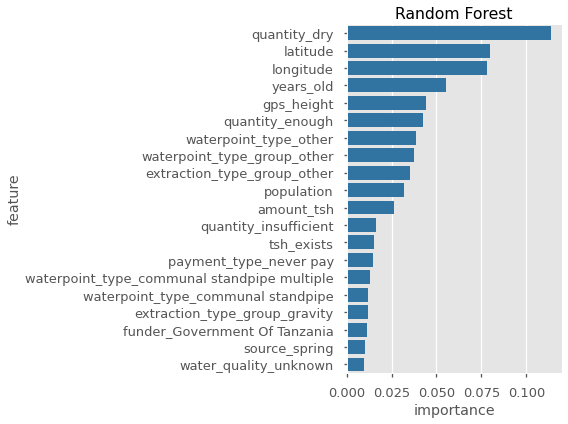

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_feature_importances(rfc_final, X_test.columns, 20, ax)
ax.set(title='Random Forest')
fig.tight_layout()

- The full Forest has feature importances based on its 100 estimators (trees).
 - You can see by inspecting the features listed that the Forest is similar to both trees above.
- The overall most important feature according to this Forest is `quantity` - namely whether or not the well is dry.
 - Presumably, dry wells are overwhelmingly non-functional / needing repair.

### Training a Mini-Forest
- Using a subset of features, we can see how a Forest performs with fewer predictors.

In [53]:
forest_importances = pd.DataFrame(rfc_final.feature_importances_, 
                                  columns=['importance'],
                                  index=X_train.columns)
top_feats = forest_importances.sort_values('importance', 
                                           ascending=False).head(11).index
top_feats

Index(['quantity_dry', 'latitude', 'longitude', 'years_old', 'gps_height',
       'quantity_enough', 'waterpoint_type_other',
       'waterpoint_type_group_other', 'extraction_type_group_other',
       'population', 'amount_tsh'],
      dtype='object')

********************************************************************************
*                  Top Features Forest Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.89      0.83      8065
functional needs repair       0.51      0.22      0.31      1079
         non functional       0.83      0.75      0.79      5706

               accuracy                           0.79     14850
              macro avg       0.70      0.62      0.64     14850
           weighted avg       0.78      0.79      0.78     14850



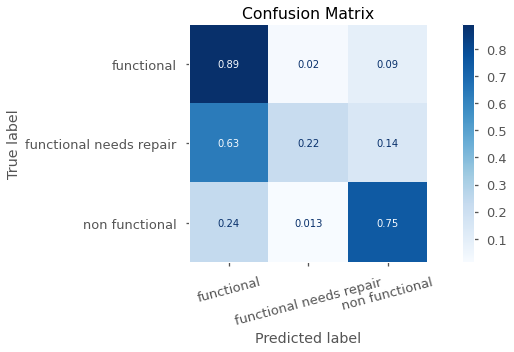

In [54]:
# Train a forest on the top features only.
params = forest_df.iloc[0]['best_params']
params['random_state'] = RANDOM_STATE

rfc_subset = RandomForestClassifier(**params)
rfc_subset.fit(X_train[top_feats], y_train)

show_metrics(rfc_subset,
             X_test[top_feats],
             y_test,
             label='Top Features Forest',
             target_names=LABEL_NAMES)

- Even a Random Forest Classifier with only the top 11 most important features still performs very well - with a 79% accuracy and 83% `non functional` precision.

# What do I look for to tell if a water pump needs maintenance?

1. **Quantity**: Pay attention to the quantity of water in the well.
 - Wells that are labeled as **dry** are almost all *non functional*.
 - Conversely, less than 25% of wells that have **enough** water are *non functional*.
 - Note: The missing values for this feature are not missing at random (ie: when the label is **unknown**, it is much more likely to be *non functional*).
- **Latitude / Longitude**: While there are functional and non functional wells spread over the country, there do seem to be "pockets" of non-functional wells. This could be due to the water source or other geographical features of an area.
 - If there is a pocket of *non functional* wells in an area, other wells in the same area might be *non functional* as well.
- **Years Old**: Determining the year the well was built and how old it is is a major factor to whether it's working or not.
 - The older a well is, the less likely it is *functional*.
 - New wells are very likely to be *functional*.
 - Wells built before **1990** are more likely to be *non functional* or *needing repair*, while after 1990 are more likely to be *functional*.
- **Extraction Type**: Determining the extraction type will help get very useful information on whether the pump is working.
 - **Gravity** pumps (the most common) are 60% likely to be *functional* and 25% to be *non functional*.
 - The most common type or well to have more *non functional* wells than *functional* is **mono**. These have over a 60% chance to be at least *in need of repair*.
 - Note: Wells that are labeled **other** have a much higher likelihood of being *non functional* than otherwise.
- **Waterpoint Type**: Certain waterpoint types have a strong predictive quality.
 - The most common **communal standpipe** is over 60% likely to be *functional* and 25% to be *non functional*.
 - Having a **communal standpipe multiple** though increases the likelihood of the pump being *non functional* quite a lot.
 - If the waterpoint type is less common (marked **other**), it is almost certainly (over 80%) *non functional*.
 - It seems that **improved spring** wells are the most likely to need repairs (these waterpoint types may require more frequent maintenance than others).
- **Amount Total Static Head**: Most wells have 0 total static head (available static water). Wells that have more than 0 **tsh** are much more likely to be *functional*.
 - As a general principal, the greater the **tsh**, the more likely it is to be *functional*.

## Quantity (dry / enough / insufficient)

********************************************************************************
*                              quantity Analysis                               *
********************************************************************************
The quantity of water
---------------------


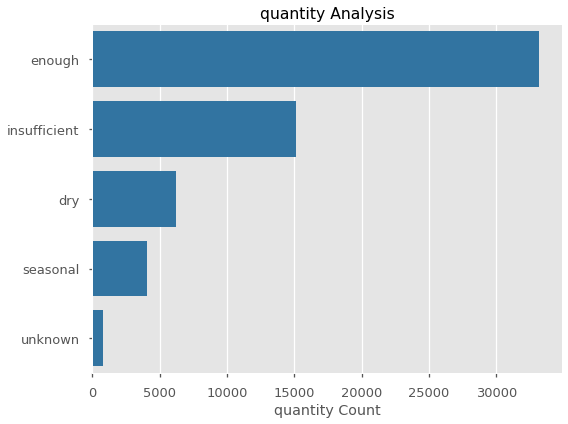


quantity - Value Counts:
------------------------


enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64


quantity - Unique Values
------------------------
5 unique values (out of 59400).

quantity - NaN:
---------------
0.0%
(0/59400)


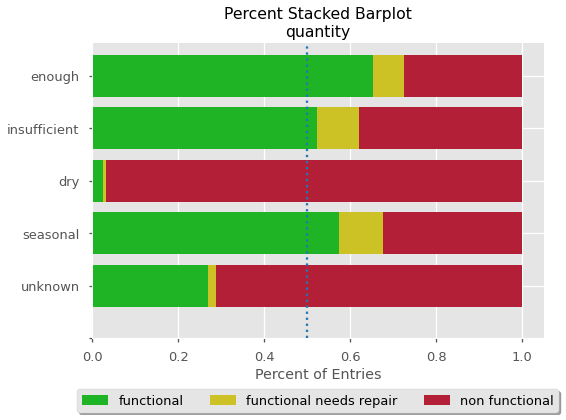

In [55]:
preliminary_eda(X_original, 'quantity', 
                interact_with_series=y_original)

## Geographical Location

In [56]:
geo_df = pd.concat([X_original, y_original], axis=1)[['status_group', 
                                                      'latitude', 
                                                      'longitude']]
geo_df = geo_df[geo_df['longitude'] > 0]  # For tidyness of data to map.

# Get a stratified sample from the geographic columns.
X_location = geo_df.drop('status_group', axis=1)
y_location = geo_df[['status_group']]
_, X_geo, _, y_geo = train_test_split(X_location, 
                                      y_location, 
                                      test_size=0.075,
                                      stratify=y_location,
                                      random_state=RANDOM_STATE)

geo_sample = pd.concat([X_geo, y_geo], axis=1)
geo_sample.shape

(4320, 3)

In [57]:
plot_on_map(geo_sample,
            color='status_group')

## Years old

********************************************************************************
*                          construction_year Analysis                          *
********************************************************************************
Year the waterpoint was constructed
-----------------------------------


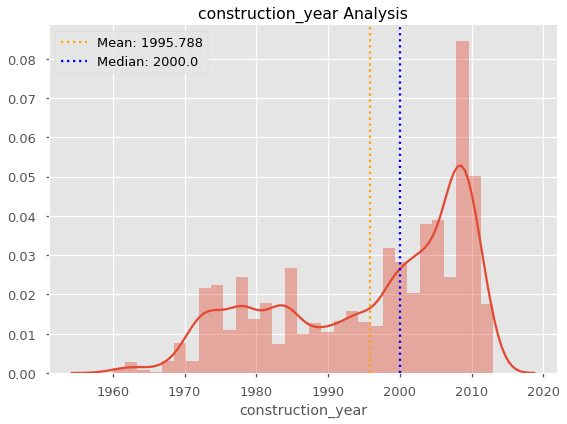


construction_year - Value Counts:
---------------------------------


2008    1693
2009    1477
2010    1196
2006     927
1978     917
2007     913
2003     865
2002     761
2000     715
2011     686
Name: construction_year, dtype: int64


construction_year - Unique Values
---------------------------------
54 unique values (out of 21934).

construction_year - NaN:
------------------------
0.0%
(0/21934)


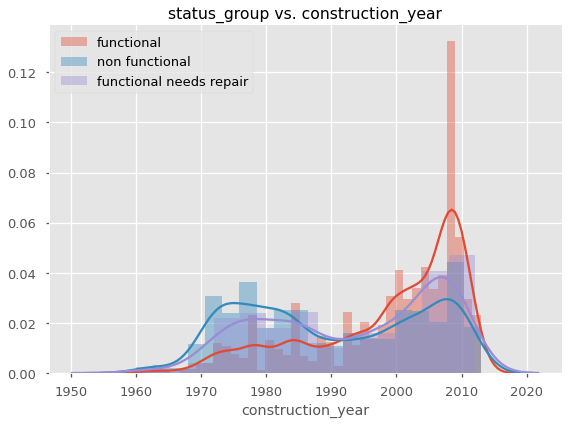

In [58]:
df_nona = pd.concat([X_original, y_original], axis=1).dropna()

preliminary_eda(df_nona[df_nona['construction_year'] > 0],
                col='construction_year',
                interact_with_col='status_group')

********************************************************************************
*                         const_year_missing Analysis                          *
********************************************************************************


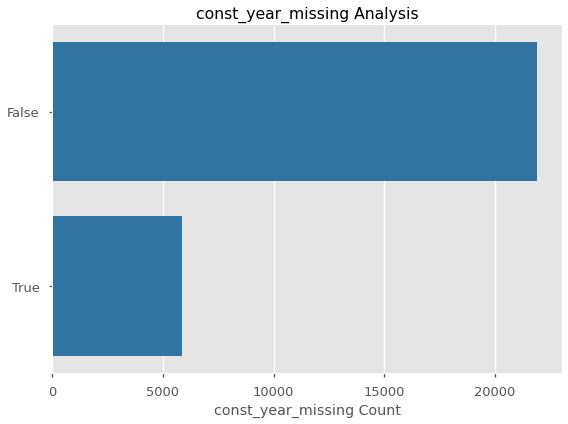


const_year_missing - Value Counts:
----------------------------------


False    21934
True      5879
Name: const_year_missing, dtype: int64


const_year_missing - Unique Values
----------------------------------
2 unique values (out of 27813).

const_year_missing - NaN:
-------------------------
0.0%
(0/27813)


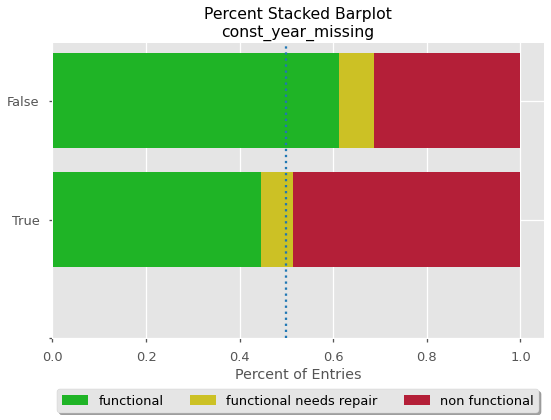

In [59]:
df_nona['const_year_missing'] = df_nona['construction_year'] == 0

preliminary_eda(df_nona, 'const_year_missing',
                interact_with_col='status_group')

## Extraction Type

********************************************************************************
*                           extraction_type Analysis                           *
********************************************************************************
The kind of extraction the waterpoint uses
------------------------------------------


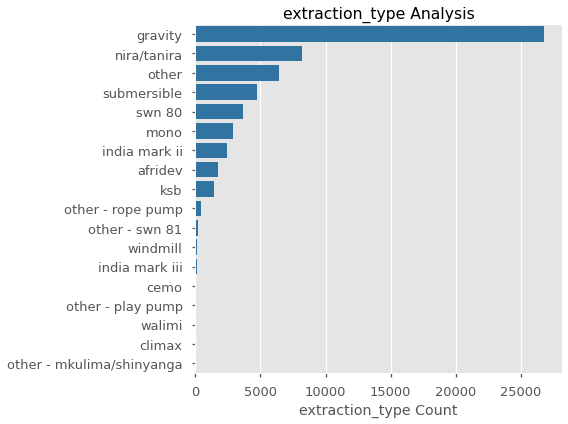


extraction_type - Value Counts:
-------------------------------


gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64


extraction_type - Unique Values
-------------------------------
18 unique values (out of 59400).

extraction_type - NaN:
----------------------
0.0%
(0/59400)


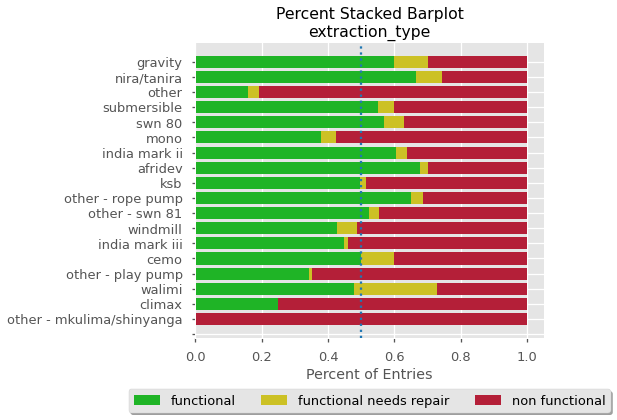

In [60]:
preliminary_eda(X_original, 'extraction_type', n_top_features=18, 
                interact_with_series=y_original)

## Waterpoint Type

********************************************************************************
*                           waterpoint_type Analysis                           *
********************************************************************************
The kind of waterpoint
----------------------


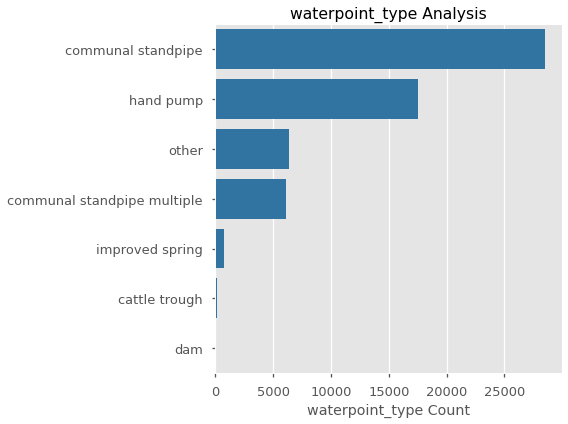


waterpoint_type - Value Counts:
-------------------------------


communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64


waterpoint_type - Unique Values
-------------------------------
7 unique values (out of 59400).

waterpoint_type - NaN:
----------------------
0.0%
(0/59400)


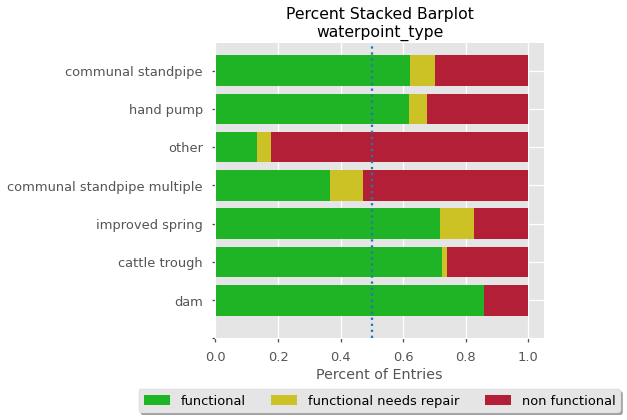

In [61]:
preliminary_eda(X_original, 'waterpoint_type', n_top_features=7, 
                interact_with_series=y_original)

## Amount Total Static Head (TSH)

********************************************************************************
*                           amount_tsh_is_0 Analysis                           *
********************************************************************************


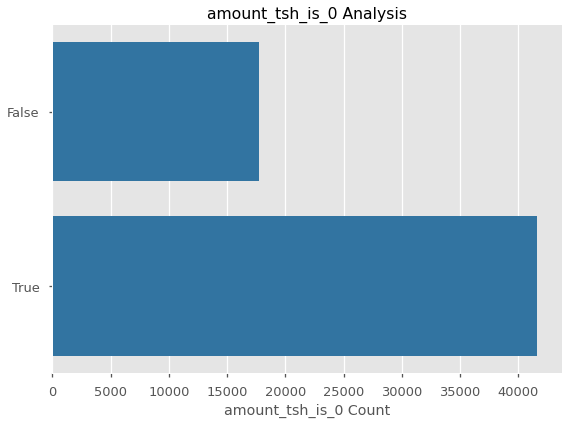


amount_tsh_is_0 - Value Counts:
-------------------------------


True     41639
False    17761
Name: amount_tsh_is_0, dtype: int64


amount_tsh_is_0 - Unique Values
-------------------------------
2 unique values (out of 59400).

amount_tsh_is_0 - NaN:
----------------------
0.0%
(0/59400)


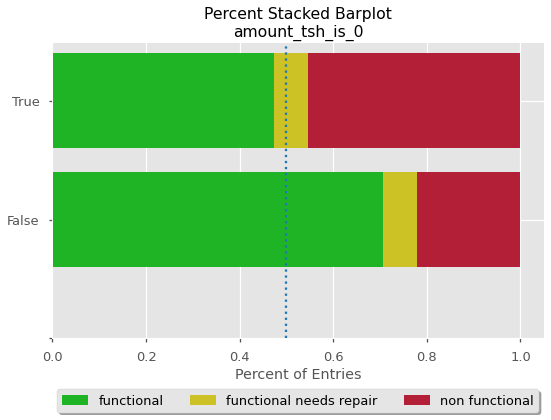

In [62]:
X_original['amount_tsh_is_0'] = X_original['amount_tsh'] == 0
preliminary_eda(X_original, 'amount_tsh_is_0', 
                interact_with_series=y_original)